In [1]:
import os
import re

from collections import defaultdict
from glob import glob
import pickle

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras_preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import itertools
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 

Using TensorFlow backend.


In [2]:
from numpy.random import seed
from tensorflow import set_random_seed

In [3]:
def _dd():
    """workaround for pickle lambda issue"""
    return defaultdict(dict)

def load_data(path, size, preproc, use_cache=True):
    
    # when use_cache is on and the cache exists then use it
    data_path = './data.pkl'
    if use_cache and os.path.exists(data_path):
        with open(data_path, 'rb') as f:
            print(f'[!] use cache from {data_path}')
            return pickle.load(f)
    
    # make nested dict
    data = defaultdict(_dd)
    
    # data augmentaion
    train_image_gen = ImageDataGenerator(rotation_range=15,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      channel_shift_range=0.1,
                      shear_range=0.,
                      zoom_range=[0.8, 1.3],
                      horizontal_flip=True,
                      vertical_flip=False,
                      data_format='channels_last',
                      brightness_range=[0.8, 1.0])
    # traverse given path
    for dataset_path in glob(f'{path}/*'):
        dataset_name = dataset_path.split('\\')[-1]
 
        tmp_x = []
        tmp_y = []

        # traverse each dataset
        for category_path in glob(f'{dataset_path}/*'):
            category_name = category_path.split('\\')[-1]

            # traverse each image in the dataset
            print(f'[+] loading {dataset_name} {category_name}')
            for image_path in glob(f'{category_path}/*'):
                # resize loaded image on the fly to avoid memory exceed
                # need to resize function for preprocessing
                tmp_x.append(img_to_array(load_img(image_path).resize((size, size))))
                tmp_y.append(category_name)

        # one-hot encoding
        lb = LabelBinarizer()
        lb.fit(tmp_y)
        y = lb.transform(tmp_y)
        train_generator = train_image_gen.flow(np.array(tmp_x), y, 
                                               shuffle=False, batch_size=32, seed=1)
        # jump 5 index for add augmentation picture
        for gen_x, gen_y in  itertools.islice(train_generator, 5):
            tmp_x = np.concatenate((tmp_x, gen_x))
            y = np.concatenate((y,gen_y))
        
        # transform loaded data
        # use preprocess_input function to implement transfer learning
        x = preproc(tmp_x)
        data[dataset_name]['x'] = x
        data[dataset_name]['y'] = y
        
    # save the cache for the faster loading after
    with open(data_path, 'wb') as f:
        pickle.dump([data, lb], f, protocol=4)
    return data, lb

In [4]:
data, enc = load_data('./data/', size=350, preproc=preprocess_input, use_cache=True)

[!] use cache from ./data.pkl


In [5]:
for dataset in data:
    print(f'{dataset} shape')
    for xy in data[dataset]:
        print(f'    {xy}: {data[dataset][xy].shape}')

test shape
    x: (996, 350, 350, 3)
    y: (996, 133)
train shape
    x: (6840, 350, 350, 3)
    y: (6840, 133)
valid shape
    x: (995, 350, 350, 3)
    y: (995, 133)


In [6]:
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Input, Dense, Dropout, Flatten
from keras import regularizers

In [7]:
base_model = InceptionResNetV2(include_top=False)

In [8]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
mixed_5b (Concatenate)          (None, None, None, 3 0           activation_6[0][0]               
                                                                 activation_8[0][0]               
                                                                 activation_11[0][0]              
                                                                 activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 3 10240       mixed_5b[0][0]                   
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, None, None, 3 96          conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_19 (Activation)      (None, None, None, 3 0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
activation_21 (Activation)      (None, None, None, 3 0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
activation_24 (Activation)      (None, None, None, 6 0           batch_normalization_24[0][0]     
__________________________________________________________________________________________________
block35_2_mixed (Concatenate)   (None, None, None, 1 0           activation_19[0][0]              
                                                                 activation_21[0][0]              
                                                                 activation_24[0][0]              
__________

__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, None, None, 3 10240       block35_3_ac[0][0]               
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, None, None, 3 9216        activation_32[0][0]              
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, None, None, 6 27648       activation_35[0][0]              
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, None, None, 3 96          conv2d_31[0][0]                  
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, None, None, 3 96          conv2d_33[0][0]                  
__________

__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, None, None, 3 10240       block35_5_ac[0][0]               
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, None, None, 4 13824       activation_46[0][0]              
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, None, None, 3 96          conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, None, None, 4 144         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_44 (Activation)      (None, None, None, 3 0           batch_normalization_44[0][0]     
__________

block35_7_conv (Conv2D)         (None, None, None, 3 41280       block35_7_mixed[0][0]            
__________________________________________________________________________________________________
block35_7 (Lambda)              (None, None, None, 3 0           block35_6_ac[0][0]               
                                                                 block35_7_conv[0][0]             
__________________________________________________________________________________________________
block35_7_ac (Activation)       (None, None, None, 3 0           block35_7[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, None, None, 3 10240       block35_7_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, None, None, 3 96          conv2d_58[0][0]                  
__________

batch_normalization_66 (BatchNo (None, None, None, 6 192         conv2d_66[0][0]                  
__________________________________________________________________________________________________
activation_61 (Activation)      (None, None, None, 3 0           batch_normalization_61[0][0]     
__________________________________________________________________________________________________
activation_63 (Activation)      (None, None, None, 3 0           batch_normalization_63[0][0]     
__________________________________________________________________________________________________
activation_66 (Activation)      (None, None, None, 6 0           batch_normalization_66[0][0]     
__________________________________________________________________________________________________
block35_9_mixed (Concatenate)   (None, None, None, 1 0           activation_61[0][0]              
                                                                 activation_63[0][0]              
          

batch_normalization_73 (BatchNo (None, None, None, 3 1152        conv2d_73[0][0]                  
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, None, None, 3 1152        conv2d_76[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, None, None, 3 0           batch_normalization_73[0][0]     
__________________________________________________________________________________________________
activation_76 (Activation)      (None, None, None, 3 0           batch_normalization_76[0][0]     
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, None, None, 3 0           block35_10_ac[0][0]              
__________________________________________________________________________________________________
mixed_6a (

conv2d_86 (Conv2D)              (None, None, None, 1 139264      block17_2_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_86 (BatchNo (None, None, None, 1 384         conv2d_86[0][0]                  
__________________________________________________________________________________________________
activation_86 (Activation)      (None, None, None, 1 0           batch_normalization_86[0][0]     
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, None, None, 1 143360      activation_86[0][0]              
__________________________________________________________________________________________________
batch_normalization_87 (BatchNo (None, None, None, 1 480         conv2d_87[0][0]                  
__________________________________________________________________________________________________
activation

conv2d_96 (Conv2D)              (None, None, None, 1 215040      activation_95[0][0]              
__________________________________________________________________________________________________
batch_normalization_93 (BatchNo (None, None, None, 1 576         conv2d_93[0][0]                  
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, None, None, 1 576         conv2d_96[0][0]                  
__________________________________________________________________________________________________
activation_93 (Activation)      (None, None, None, 1 0           batch_normalization_93[0][0]     
__________________________________________________________________________________________________
activation_96 (Activation)      (None, None, None, 1 0           batch_normalization_96[0][0]     
__________________________________________________________________________________________________
block17_5_

__________________________________________________________________________________________________
block17_7 (Lambda)              (None, None, None, 1 0           block17_6_ac[0][0]               
                                                                 block17_7_conv[0][0]             
__________________________________________________________________________________________________
block17_7_ac (Activation)       (None, None, None, 1 0           block17_7[0][0]                  
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, None, None, 1 139264      block17_7_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, None, None, 1 384         conv2d_106[0][0]                 
__________________________________________________________________________________________________
activation

batch_normalization_115 (BatchN (None, None, None, 1 480         conv2d_115[0][0]                 
__________________________________________________________________________________________________
activation_115 (Activation)     (None, None, None, 1 0           batch_normalization_115[0][0]    
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, None, None, 1 208896      block17_9_ac[0][0]               
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, None, None, 1 215040      activation_115[0][0]             
__________________________________________________________________________________________________
batch_normalization_113 (BatchN (None, None, None, 1 576         conv2d_113[0][0]                 
__________________________________________________________________________________________________
batch_norm

activation_124 (Activation)     (None, None, None, 1 0           batch_normalization_124[0][0]    
__________________________________________________________________________________________________
block17_12_mixed (Concatenate)  (None, None, None, 3 0           activation_121[0][0]             
                                                                 activation_124[0][0]             
__________________________________________________________________________________________________
block17_12_conv (Conv2D)        (None, None, None, 1 418880      block17_12_mixed[0][0]           
__________________________________________________________________________________________________
block17_12 (Lambda)             (None, None, None, 1 0           block17_11_ac[0][0]              
                                                                 block17_12_conv[0][0]            
__________________________________________________________________________________________________
block17_12

batch_normalization_134 (BatchN (None, None, None, 1 384         conv2d_134[0][0]                 
__________________________________________________________________________________________________
activation_134 (Activation)     (None, None, None, 1 0           batch_normalization_134[0][0]    
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, None, None, 1 143360      activation_134[0][0]             
__________________________________________________________________________________________________
batch_normalization_135 (BatchN (None, None, None, 1 480         conv2d_135[0][0]                 
__________________________________________________________________________________________________
activation_135 (Activation)     (None, None, None, 1 0           batch_normalization_135[0][0]    
__________________________________________________________________________________________________
conv2d_133

batch_normalization_141 (BatchN (None, None, None, 1 576         conv2d_141[0][0]                 
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, None, None, 1 576         conv2d_144[0][0]                 
__________________________________________________________________________________________________
activation_141 (Activation)     (None, None, None, 1 0           batch_normalization_141[0][0]    
__________________________________________________________________________________________________
activation_144 (Activation)     (None, None, None, 1 0           batch_normalization_144[0][0]    
__________________________________________________________________________________________________
block17_17_mixed (Concatenate)  (None, None, None, 3 0           activation_141[0][0]             
                                                                 activation_144[0][0]             
__________

                                                                 block17_19_conv[0][0]            
__________________________________________________________________________________________________
block17_19_ac (Activation)      (None, None, None, 1 0           block17_19[0][0]                 
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, None, None, 1 139264      block17_19_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_154 (BatchN (None, None, None, 1 384         conv2d_154[0][0]                 
__________________________________________________________________________________________________
activation_154 (Activation)     (None, None, None, 1 0           batch_normalization_154[0][0]    
__________________________________________________________________________________________________
conv2d_155

mixed_7a (Concatenate)          (None, None, None, 2 0           activation_158[0][0]             
                                                                 activation_160[0][0]             
                                                                 activation_163[0][0]             
                                                                 max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
conv2d_165 (Conv2D)             (None, None, None, 1 399360      mixed_7a[0][0]                   
__________________________________________________________________________________________________
batch_normalization_165 (BatchN (None, None, None, 1 576         conv2d_165[0][0]                 
__________________________________________________________________________________________________
activation_165 (Activation)     (None, None, None, 1 0           batch_normalization_165[0][0]    
__________

__________________________________________________________________________________________________
activation_174 (Activation)     (None, None, None, 2 0           batch_normalization_174[0][0]    
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, None, None, 1 399360      block8_2_ac[0][0]                
__________________________________________________________________________________________________
conv2d_175 (Conv2D)             (None, None, None, 2 172032      activation_174[0][0]             
__________________________________________________________________________________________________
batch_normalization_172 (BatchN (None, None, None, 1 576         conv2d_172[0][0]                 
__________________________________________________________________________________________________
batch_normalization_175 (BatchN (None, None, None, 2 768         conv2d_175[0][0]                 
__________

__________________________________________________________________________________________________
block8_5_mixed (Concatenate)    (None, None, None, 4 0           activation_180[0][0]             
                                                                 activation_183[0][0]             
__________________________________________________________________________________________________
block8_5_conv (Conv2D)          (None, None, None, 2 933920      block8_5_mixed[0][0]             
__________________________________________________________________________________________________
block8_5 (Lambda)               (None, None, None, 2 0           block8_4_ac[0][0]                
                                                                 block8_5_conv[0][0]              
__________________________________________________________________________________________________
block8_5_ac (Activation)        (None, None, None, 2 0           block8_5[0][0]                   
__________

__________________________________________________________________________________________________
activation_193 (Activation)     (None, None, None, 1 0           batch_normalization_193[0][0]    
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, None, None, 2 129024      activation_193[0][0]             
__________________________________________________________________________________________________
batch_normalization_194 (BatchN (None, None, None, 2 672         conv2d_194[0][0]                 
__________________________________________________________________________________________________
activation_194 (Activation)     (None, None, None, 2 0           batch_normalization_194[0][0]    
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, None, None, 1 399360      block8_7_ac[0][0]                
__________

__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, None, None, 2 768         conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_200 (Activation)     (None, None, None, 1 0           batch_normalization_200[0][0]    
__________________________________________________________________________________________________
activation_203 (Activation)     (None, None, None, 2 0           batch_normalization_203[0][0]    
__________________________________________________________________________________________________
block8_10_mixed (Concatenate)   (None, None, None, 4 0           activation_200[0][0]             
                                                                 activation_203[0][0]             
__________________________________________________________________________________________________
block8_10_

In [9]:
data['train']['pre'] = base_model.predict(data['train']['x'])
data['test']['pre'] = base_model.predict(data['test']['x'])
data['valid']['pre'] = base_model.predict(data['valid']['x'])

In [10]:
input_shape = data['train']['pre'].shape[1:]

In [11]:
def draw_graph(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [12]:
def search_grid_model(model_string, grid):
    """
    Search the best hyper parameters which for the model with the grid.
    For the sake of simplicity, all random seeds are fixed to 42.
    """
    
#    seed(42)
#    set_random_seed(42)
#    os.environ['PYTHONHASHSEED'] = '42'
    
    for hyper_parameters in grid:
        # define top_detection_model
        model = model_string
        
        for idx, hyper_parameter in enumerate(hyper_parameters, 1):
            #?
            if isinstance(hyper_parameter, str):
                hyper_parameter = f"'{hyper_parameter}'"
            model = re.sub(f'@{idx}', str(hyper_parameter), model)
        # exec
        # globals
        exec(model, globals())
        opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.005, amsgrad=False)
        top_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        # earlystopping
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4, verbose=1, mode='auto')
        checkpoint = ModelCheckpoint(filepath=('./saved_model/best.hdf5'), verbose=0,
                                       save_best_only=True, mode='auto')
        
        history = top_model.fit(data['train']['pre'], data['train']['y'],
                                validation_data=(data['valid']['pre'], data['valid']['y']), shuffle=True,
                                callbacks=[checkpoint], verbose=0,
                                epochs=100, batch_size=100)
        
        top_model.load_weights('./saved_model/best.hdf5')
        skin_prediction = np.argmax(top_model.predict(data['test']['pre']), 1)
        skin_truth = np.asarray(np.argmax(data['test']['y'], 1)).reshape(-1)
        test_accuracy = 100*np.sum(skin_prediction == skin_truth)/len(skin_truth)
        print(hyper_parameters, test_accuracy, len(history.history['acc']))
        draw_graph(history)

[256, 128] 89.1566265060241 100


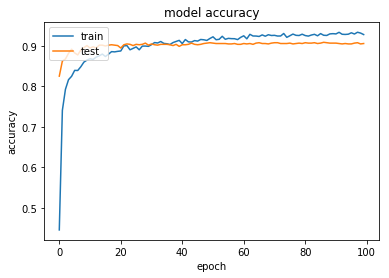

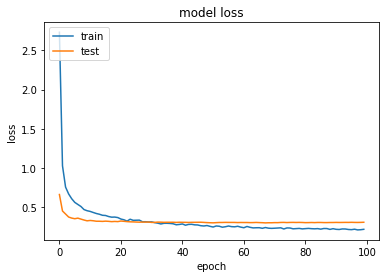

[512, 256] 88.65461847389558 100


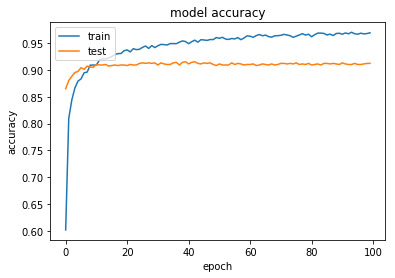

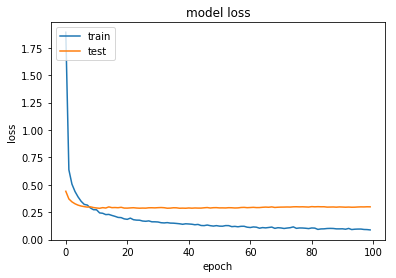

[1024, 256] 89.2570281124498 100


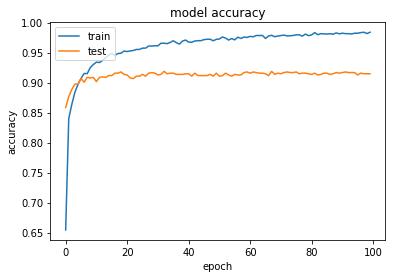

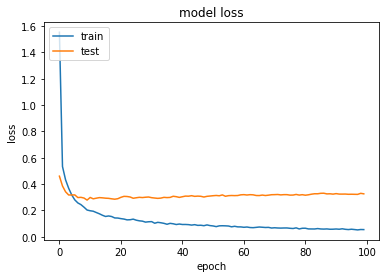

In [13]:
model_string = """
top_model = Sequential()
top_model.add(BatchNormalization(input_shape=input_shape))
top_model.add(GlobalAveragePooling2D())
top_model.add(Dense(@1, activation='relu'))
top_model.add(Dropout(0.4))
top_model.add(Dense(@2, activation='relu'))
top_model.add(Dropout(0.4))
top_model.add(Dense(133, activation='softmax'))
"""

search_grid_model(model_string, [[256,128], [512,256], [1024,256]])

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Input, Dense, Dropout, Flatten
from keras import regularizers
top_model = Sequential()
top_model.add(GlobalAveragePooling2D())
top_model.add(Dense(512, activation='relu',
                   kernel_regularizer=regularizers.l2(0.01),
                   activity_regularizer=regularizers.l2(0.01)))
top_model.add(Dropout(0.3))
top_model.add(Dense(256, activation='relu',
                   kernel_regularizer=regularizers.l2(0.01),
                   activity_regularizer=regularizers.l2(0.01)))
top_model.add(Dropout(0.3))
top_model.add(Dense(3, activation='softmax'))
#add for predicting